## Notebook sobre el caso MEF

In [1]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd

import re

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

import unicodedata

from wordcloud import WordCloud

In [2]:
nltk.download("punkt", download_dir="D:/Maestria/mef/nltk_data")  # para el mapa de palabras
nltk.data.path.append("D:/Maestria/mef/nltk_data")

nltk.download("stopwords")
palabras_vacias = set(stopwords.words("spanish"))

[nltk_data] Downloading package punkt to D:/Maestria/mef/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhoee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 1. Conexion a base de datos

In [3]:
load_dotenv()

True

In [4]:
servidor = os.getenv("SERVIDOR")
base_datos = os.getenv("BASE_DATOS")
driver = os.getenv("DRIVER")

cadena_conexion = (
    f"mssql+pyodbc://@{servidor}/{base_datos}"
    f"?driver={driver.replace(' ', '+')}"
    f"&Trusted_Connection=yes"
    f"&TrustServerCertificate=yes"
)

motor = create_engine(cadena_conexion)

#### 2. Cargar Tablas

In [5]:
dim_ejecutora = pd.read_sql("""
    SELECT [EJECUTORA_ID]
        ,[COD_DEPARTAMENTO_EJEC]
        ,[COD_PROVINCIA_EJEC]
        ,[COD_DISTRITO_EJEC]
        ,[RUC_EJEC]
        ,[ANIO_EJE]
        ,[ID_EJECUTORA]
        ,[SEC_EJEC]
        ,[NOMBRE]
        ,[TIPO_UNIDAD]
    FROM [DMT_GASTO_MEF].[dbo].[DIM_EJECUTORA]
""", motor)

In [6]:
dim_ejecutora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   EJECUTORA_ID           487 non-null    int64 
 1   COD_DEPARTAMENTO_EJEC  487 non-null    object
 2   COD_PROVINCIA_EJEC     487 non-null    object
 3   COD_DISTRITO_EJEC      487 non-null    object
 4   RUC_EJEC               487 non-null    object
 5   ANIO_EJE               487 non-null    int64 
 6   ID_EJECUTORA           487 non-null    object
 7   SEC_EJEC               487 non-null    int64 
 8   NOMBRE                 487 non-null    object
 9   TIPO_UNIDAD            487 non-null    object
dtypes: int64(3), object(7)
memory usage: 38.2+ KB


In [7]:
dim_ejecutora.sample(5, random_state=42)

,EJECUTORA_ID,COD_DEPARTAMENTO_EJEC,COD_PROVINCIA_EJEC,COD_DISTRITO_EJEC,RUC_EJEC,ANIO_EJE,ID_EJECUTORA,SEC_EJEC,NOMBRE,TIPO_UNIDAD
72,72,15,08,01,20172299742,2012,001,108,UNIVERSIDAD NACIONAL FAUSTINO SANCHEZ CARRION,E
244,244,15,01,01,20169004359,2017,001,92,UNIVERSIDAD NACIONAL DE INGENIERIA,E
437,437,16,01,01,20180260316,2018,001,97,UNIVERSIDAD NACIONAL DE LA AMAZONIA PERUANA,E
79,79,02,18,01,20148309109,2014,001,114,UNIVERSIDAD NACIONAL DEL SANTA,E
402,402,09,01,01,20168014962,2017,001,115,UNIVERSIDAD NACIONAL DE HUANCAVELICA,E


In [8]:
len(dim_ejecutora.value_counts(subset="NOMBRE"))

56

Parece que hay 56 universidades unicas

In [9]:
dim_ubigeo = pd.read_sql("""
SELECT TOP (1000) [UBIGEO_ID]
        ,[UBIGEO_RENIEC]
        ,[UBIGEO_INEI]
        ,[DEPARTAMENTO_INEI]
        ,[DEPARTAMENTO]
        ,[PROVINCIA_INEI]
        ,[PROVINCIA]
        ,[DISTRITO]
        ,[REGION]
        ,[MACROREGION_INEI]
        ,[MACROREGION_MINSA]
        ,[CODIGO_FIPS]
        ,[SUPERFICIE]
        ,[ALTITUD]
        ,[LATITUD]
        ,[LONGITUD]
        ,[POBLACION_DISTRITO]
        ,[POBLACION_PROVINCIA]
        ,[POBLACION_DEPARTAMENTO]
        ,[DIRESA]
    FROM [DMT_GASTO_MEF].[dbo].[DIM_UBIGEO]
""", motor)

In [10]:
dim_ubigeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UBIGEO_ID               1000 non-null   int64  
 1   UBIGEO_RENIEC           1000 non-null   object 
 2   UBIGEO_INEI             1000 non-null   object 
 3   DEPARTAMENTO_INEI       1000 non-null   object 
 4   DEPARTAMENTO            1000 non-null   object 
 5   PROVINCIA_INEI          1000 non-null   object 
 6   PROVINCIA               1000 non-null   object 
 7   DISTRITO                1000 non-null   object 
 8   REGION                  1000 non-null   object 
 9   MACROREGION_INEI        1000 non-null   object 
 10  MACROREGION_MINSA       1000 non-null   object 
 11  CODIGO_FIPS             1000 non-null   object 
 12  SUPERFICIE              996 non-null    float64
 13  ALTITUD                 1000 non-null   int64  
 14  LATITUD                 1000 non-null   f

In [11]:
dim_ubigeo.sample(5, random_state=42)

,UBIGEO_ID,UBIGEO_RENIEC,UBIGEO_INEI,DEPARTAMENTO_INEI,DEPARTAMENTO,PROVINCIA_INEI,PROVINCIA,DISTRITO,REGION,MACROREGION_INEI,MACROREGION_MINSA,CODIGO_FIPS,SUPERFICIE,ALTITUD,LATITUD,LONGITUD,POBLACION_DISTRITO,POBLACION_PROVINCIA,POBLACION_DEPARTAMENTO,DIRESA
521,6794,050616,050708,05,AYACUCHO,0507,PARINACOCHAS,UPAHUACHO,AYACUCHO,CENTRO,MACROREGION CENTRO,5,587.0,3341,-14.9072,-73.3975,1585,26461,696504,AYACUCHO
737,7010,070601,080601,08,CUSCO,0806,CANCHIS,SICUANI,CUSCO,SUR,MACROREGION SUR,8,646.0,3593,-14.2381,-71.2308,66376,112783,1471345,CUSCO
740,7013,070604,080604,08,CUSCO,0806,CANCHIS,MARANGANI,CUSCO,SUR,MACROREGION SUR,8,433.0,3720,-14.3567,-71.1686,11741,112783,1471345,CUSCO
660,6933,061204,061006,06,CAJAMARCA,0610,SAN MARCOS,JOSE MANUEL QUIROZ,CAJAMARCA,NORTE,MACROREGION NORTE,6,115.0,2781,-7.3494,-78.0478,4355,58393,1614623,CAJAMARCA
411,6684,040213,040513,04,AREQUIPA,0405,CAYLLOMA,MADRIGAL,AREQUIPA,SUR,MACROREGION SUR,4,160.0,3300,-15.6083,-71.8075,821,105492,1568544,AREQUIPA


In [12]:
df_universidades = dim_ejecutora[['NOMBRE', 'COD_DEPARTAMENTO_EJEC', "EJECUTORA_ID"]].drop_duplicates(subset='NOMBRE').reset_index(drop=True)
df_universidades.shape

(56, 3)

Siguen siendo las 56 universidades

In [13]:
df_universidades.head()

,NOMBRE,COD_DEPARTAMENTO_EJEC,EJECUTORA_ID
0,SIN DATOS,99,-1
1,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,05,1
2,UNIVERSIDAD NACIONAL DANIEL ALCIDES CARRION,19,2
3,UNIVERSIDAD NACIONAL TORIBIO RODRIGUEZ DE MEND...,01,3
4,UNIVERSIDAD NACIONAL DEL CENTRO DEL PERU,12,4


Sin embargo, hay una fila sin datos que se removera

In [14]:
df_universidades = df_universidades.iloc[1:].reset_index(drop=True).copy()
df_universidades.head()

,NOMBRE,COD_DEPARTAMENTO_EJEC,EJECUTORA_ID
0,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,05,1
1,UNIVERSIDAD NACIONAL DANIEL ALCIDES CARRION,19,2
2,UNIVERSIDAD NACIONAL TORIBIO RODRIGUEZ DE MEND...,01,3
3,UNIVERSIDAD NACIONAL DEL CENTRO DEL PERU,12,4
4,UNIVERSIDAD NACIONAL DEL SANTA,02,5


#### Mapa de palabras

Primero, convertimos a una lista

In [15]:
df_universidades["NOMBRE"].to_list()[:3]

['UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA',
 'UNIVERSIDAD NACIONAL DANIEL ALCIDES CARRION',
 'UNIVERSIDAD NACIONAL TORIBIO RODRIGUEZ DE MENDOZA DE AMAZONAS']

In [16]:
lista_nombres = df_universidades["NOMBRE"].to_list()

# convierte a minusculas
lista_nombres_minuscula = []

for nombre in lista_nombres:
    nombre_limpio = nombre.lower()
    lista_nombres_minuscula.append(nombre_limpio)

# quita signos de puntuacion
lista_nombres_sin_signos = []

for nombre in lista_nombres_minuscula:
    nombre_limpio = re.sub(r"[^a-záéíóúñü\s]", "", nombre)
    lista_nombres_sin_signos.append(nombre_limpio)

# quita tildes
lista_normalizada = []

for nombre in lista_nombres_sin_signos:
    nombre_sin_tildes = unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8')
    lista_normalizada.append(nombre_sin_tildes)

# tokeniza
lista_tokens = []

for nombre in lista_normalizada:
    tokens = wordpunct_tokenize(nombre)
    lista_tokens.append(tokens)

# elmina stopwords
palabras_vacias = set(stopwords.words("spanish"))
tokens_limpios = []

for lista in lista_tokens:
    palabras_filtradas = []

    for palabra in lista:
        if palabra not in palabras_vacias and len(palabra) > 2:
            palabras_filtradas.append(palabra)

    tokens_limpios.append(palabras_filtradas)

# une los tokens
lista_final = []

for lista in tokens_limpios:
    for palabra in lista:
        lista_final.append(palabra)

texto_total = " ".join(lista_final)
texto_total[:10]  # ejmplo de 10

'universida'

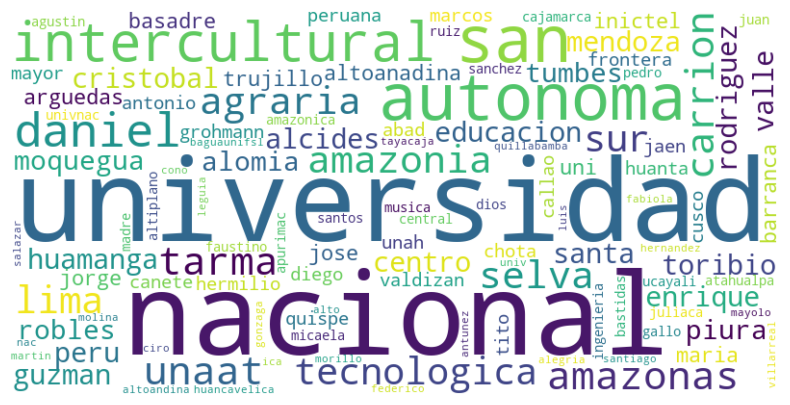

In [17]:
nube = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(texto_total)

plt.figure(figsize=(10, 5))
plt.imshow(nube, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Merge

Se realiza el merge para asignar el departamento correspondiente a cada universidad

In [18]:
dim_ubigeo_unico = dim_ubigeo.drop_duplicates(subset='DEPARTAMENTO_INEI')
dim_ubigeo_unico[["DEPARTAMENTO_INEI", "DEPARTAMENTO"]]

,DEPARTAMENTO_INEI,DEPARTAMENTO
0,99,99
1,01,AMAZONAS
85,02,ANCASH
251,03,APURIMAC
335,04,AREQUIPA
444,05,AYACUCHO
563,06,CAJAMARCA
690,07,CALLAO
697,08,CUSCO
809,09,HUANCAVELICA


In [19]:
df_combinado = df_universidades.merge(
    dim_ubigeo_unico,
    left_on='COD_DEPARTAMENTO_EJEC',
    right_on='DEPARTAMENTO_INEI',
    how='left'
)
df_uni_depa = df_combinado[['COD_DEPARTAMENTO_EJEC', 'NOMBRE', 'DEPARTAMENTO', "EJECUTORA_ID"]]
df_uni_depa.sample(5, random_state=42)

,COD_DEPARTAMENTO_EJEC,NOMBRE,DEPARTAMENTO,EJECUTORA_ID
31,03,UNIVERSIDAD NACIONAL MICAELA BASTIDAS DE APURIMAC,APURIMAC,49
5,15,UNIVERSIDAD NACIONAL DE EDUCACION ENRIQUE GUZM...,NaN,6
32,17,UNIVERSIDAD NACIONAL AMAZONICA DE MADRE DE DIOS,NaN,51
13,12,U. N. AUTÓNOMA ALTOANADINA DE TARMA - UNAAT,NaN,16
19,06,UNIVERSIDAD NACIONAL AUTONOMA DE CHOTA,CAJAMARCA,24


Sin embargo, se observa que no se cuenta con la informacion de todos los departamentos debido a los NaN luego de hacer el merge

In [20]:
dim_ubigeo_unico = dim_ubigeo.drop_duplicates(subset='DEPARTAMENTO_INEI')
dim_ubigeo_unico.shape

(12, 20)

Efectivamente, solo estan los identificadores de 12 departamentos de los 24 del Peru.  Para completar estos datos faltantes, se utilizara la data de https://datosabiertos.gob.pe/dataset/codigos-equivalentes-de-ubigeo-del-peru

In [21]:
df_codigos = pd.read_csv("data\\TB_UBIGEOS.csv", sep=';')
df_codigos.head(3)

,id_ubigeo,ubigeo_reniec,ubigeo_inei,departamento_inei,departamento,provincia_inei,provincia,distrito,region,macroregion_inei,macroregion_minsa,iso_3166_2,fips,superficie,altitud,latitud,longitud,Frontera
0,1,10101.0,10101,1,AMAZONAS,101,CHACHAPOYAS,CHACHAPOYAS,AMAZONAS,ORIENTE,MACROREGION ORIENTE,PE-AMA,1,154.0,2338.0,"-6,2294","-77,8728",NO
1,2,10102.0,10102,1,AMAZONAS,101,CHACHAPOYAS,ASUNCION,AMAZONAS,ORIENTE,MACROREGION ORIENTE,PE-AMA,1,26.0,2823.0,"-6,0325","-77,7108",NO
2,3,10103.0,10103,1,AMAZONAS,101,CHACHAPOYAS,BALSAS,AMAZONAS,ORIENTE,MACROREGION ORIENTE,PE-AMA,1,357.0,859.0,"-6,8358","-78,0197",NO


In [22]:
df_cod_depa = df_codigos[['departamento_inei', 'departamento']].drop_duplicates().reset_index(drop=True)
df_cod_depa

,departamento_inei,departamento
0,1,AMAZONAS
1,2,ANCASH
2,3,APURIMAC
3,4,AREQUIPA
4,5,AYACUCHO
5,6,CAJAMARCA
6,7,CALLAO
7,8,CUSCO
8,9,HUANCAVELICA
9,10,HUANUCO


In [23]:
df_cod_depa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   departamento_inei  25 non-null     int64 
 1   departamento       25 non-null     object
dtypes: int64(1), object(1)
memory usage: 532.0+ bytes


Como los codigos estan almacenados como numeros enteros, hay que convertirlos a strings

In [24]:
df_cod_depa['departamento_inei'] = df_cod_depa['departamento_inei'].astype(str)

y remover los ceros adelante del df de universidades

In [25]:
df_universidades.loc[:, 'COD_DEPARTAMENTO_EJEC'] = df_universidades['COD_DEPARTAMENTO_EJEC'].astype(str).str.lstrip('0')


Ahora si, se completaran los datos NaN

In [26]:
df_combinado_correcto = df_universidades.merge(
    df_cod_depa,
    left_on='COD_DEPARTAMENTO_EJEC',
    right_on='departamento_inei',
    how='left'
)
df_uni_depa_corr = df_combinado_correcto[['NOMBRE', 'departamento', "EJECUTORA_ID"]]
df_uni_depa_corr.sample(5, random_state=42)

,NOMBRE,departamento,EJECUTORA_ID
31,UNIVERSIDAD NACIONAL MICAELA BASTIDAS DE APURIMAC,APURIMAC,49
5,UNIVERSIDAD NACIONAL DE EDUCACION ENRIQUE GUZM...,LIMA,6
32,UNIVERSIDAD NACIONAL AMAZONICA DE MADRE DE DIOS,MADRE DE DIOS,51
13,U. N. AUTÓNOMA ALTOANADINA DE TARMA - UNAAT,JUNIN,16
19,UNIVERSIDAD NACIONAL AUTONOMA DE CHOTA,CAJAMARCA,24


In [27]:
conteo = df_uni_depa_corr['departamento'].value_counts().reset_index()
conteo.columns = ['departamento', 'cantidad_universidades']

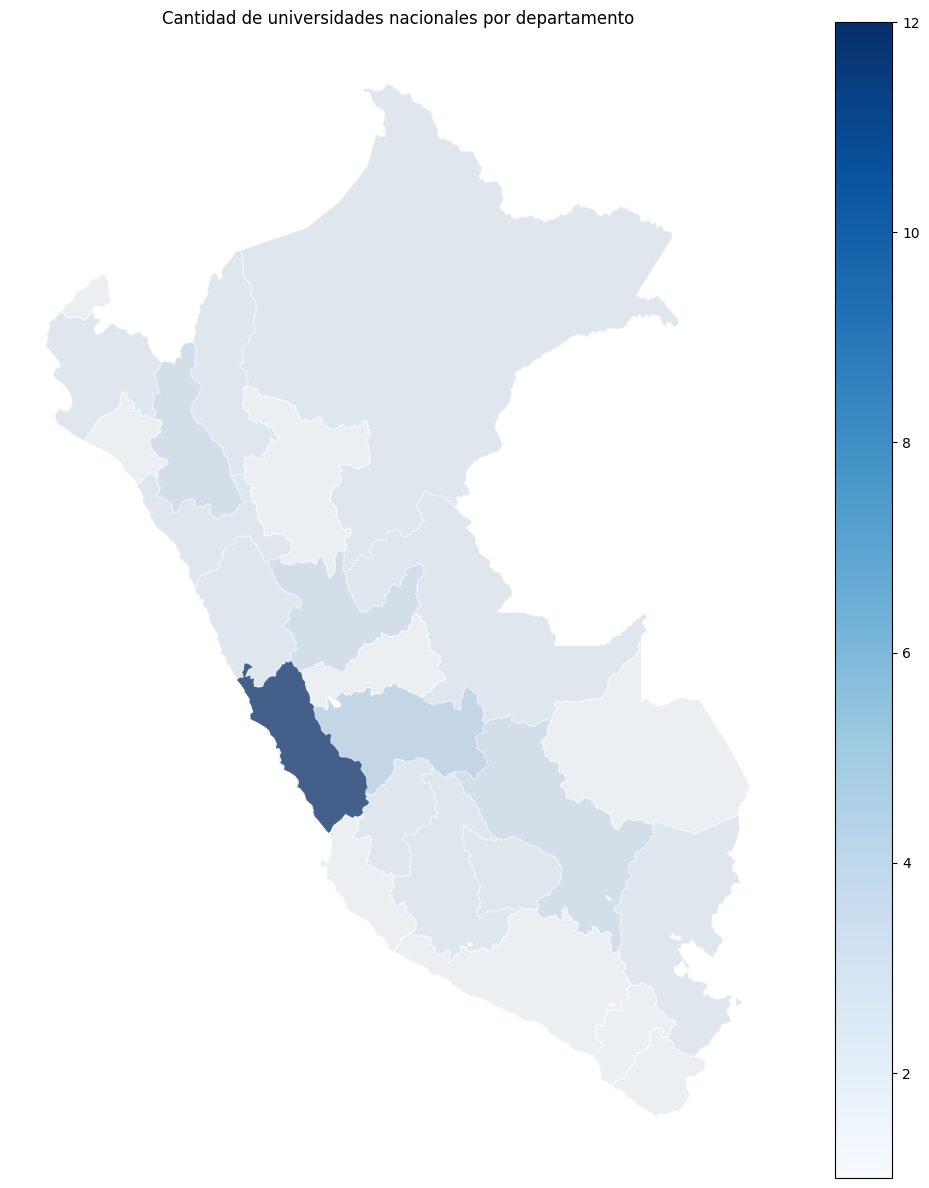

In [28]:
gdf = gpd.read_file("peru_departamental_simple.geojson")

mapa_peru = gdf.merge(
    conteo,
    left_on='NOMBDEP',
    right_on='departamento',
    how='left'
)
mapa_peru['cantidad_universidades'] = mapa_peru['cantidad_universidades'].fillna(0)

fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')  # mapa base

mapa_peru.plot(
    ax=ax,
    markersize=mapa_peru['cantidad_universidades'] * 100,  # escalas
    column='cantidad_universidades',
    cmap='Blues',
    legend=True,
    alpha=0.7
)

plt.title('Cantidad de universidades nacionales por departamento')
plt.axis('off')
plt.tight_layout()
plt.show()

#### Gastos por universidad

In [29]:
df_gastos = pd.read_sql("""
SELECT [UBIGEO_ID]
    ,[EJECUTORA_ID]
    ,[FUENTE_ID]
    ,[NIVEL_GOBIERNO_ID]
    ,[PLIEGO_ID]
    ,[SECTOR_ID]
    ,[PROGRAMA_ID]
    ,[PROGRAMA_PPTO_ID]
    ,[ESPECIFICA_DET_ID]
    ,[RUBRO_ID]
    ,[CATEGORIA_GASTO_ID]
    ,[UNIDAD_MEDIDA_ID]
    ,[FINALIDAD_ID]
    ,[ANIO_ID]
    ,[PIA]
    ,[PIM]
    ,[Certificado]
    ,[CompAnual]
    ,[AtencionCompMensual]
    ,[Devengado]
    ,[Girado]
    FROM [DMT_GASTO_MEF].[dbo].[FACT_GASTO_MEF]
""", motor)

In [30]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532521 entries, 0 to 532520
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   UBIGEO_ID            532521 non-null  int64  
 1   EJECUTORA_ID         532521 non-null  int64  
 2   FUENTE_ID            532521 non-null  int64  
 3   NIVEL_GOBIERNO_ID    532521 non-null  int64  
 4   PLIEGO_ID            532521 non-null  int64  
 5   SECTOR_ID            532521 non-null  int64  
 6   PROGRAMA_ID          532521 non-null  int64  
 7   PROGRAMA_PPTO_ID     532521 non-null  int64  
 8   ESPECIFICA_DET_ID    532521 non-null  int64  
 9   RUBRO_ID             532521 non-null  int64  
 10  CATEGORIA_GASTO_ID   532521 non-null  int64  
 11  UNIDAD_MEDIDA_ID     532521 non-null  int64  
 12  FINALIDAD_ID         532521 non-null  int64  
 13  ANIO_ID              532521 non-null  int64  
 14  PIA                  532521 non-null  float64
 15  PIM              

In [31]:
df_gastos

,UBIGEO_ID,EJECUTORA_ID,FUENTE_ID,NIVEL_GOBIERNO_ID,PLIEGO_ID,SECTOR_ID,PROGRAMA_ID,PROGRAMA_PPTO_ID,ESPECIFICA_DET_ID,RUBRO_ID,...,UNIDAD_MEDIDA_ID,FINALIDAD_ID,ANIO_ID,PIA,PIM,Certificado,CompAnual,AtencionCompMensual,Devengado,Girado
0,6533,349,5,1,396,5,120,25,551,12,...,236,1344,2016,3000.0,280.0,280.0,0.0,280.0,280.0,280.0
1,6909,32,5,1,265,5,120,25,550,12,...,236,1344,2016,3300.0,3138.0,3138.0,0.0,3138.0,3138.0,3138.0
2,6909,32,5,1,265,5,120,25,551,12,...,236,1344,2016,0.0,715.0,715.0,0.0,715.0,715.0,715.0
3,7595,263,5,1,205,5,120,25,1300,12,...,236,1344,2016,0.0,15729.0,15729.0,0.0,15729.0,15729.0,15729.0
4,8135,317,5,1,18,5,120,25,2662,12,...,236,1344,2016,3260.0,3260.0,3260.0,0.0,3260.0,3260.0,3260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532516,7542,91,13,1,448,3,95,18,2193,5,...,236,1344,2014,0.0,0.0,0.0,0.0,35.7,35.7,35.7
532517,7542,91,13,1,448,3,95,18,2982,5,...,236,1344,2014,0.0,0.0,0.0,0.0,1000.0,1000.0,1000.0
532518,7542,91,13,1,448,3,95,18,1832,5,...,236,1344,2014,0.0,0.0,0.0,0.0,1509.0,1509.0,1509.0
532519,7542,91,13,1,448,3,95,18,2778,5,...,236,1344,2014,0.0,0.0,0.0,0.0,9475.0,9475.0,9475.0


In [32]:
df_gastos_agrupado = df_gastos.groupby(['EJECUTORA_ID', 'ANIO_ID'], as_index=False)[
    ['PIA', 'PIM', 'Certificado', 'CompAnual', 'Devengado', 'Girado']
].sum()

In [33]:
anhos = df_gastos_agrupado['ANIO_ID'].drop_duplicates()
anhos = anhos.drop(index=255).reset_index(drop=True)
anhos

0    2019
1    2016
2    2017
3    2012
4    2020
5    2021
6    2014
7    2015
8    2018
9    2013
Name: ANIO_ID, dtype: int64

In [34]:
df_cruzado = df_uni_depa_corr.assign(key=1).merge(
    anhos.to_frame(name='ANIO_ID').assign(key=1),
    on='key'
).drop(columns='key')


df_final = df_cruzado.merge(
    df_gastos_agrupado,
    on=['EJECUTORA_ID', 'ANIO_ID'],
    how='left'
)
df_final

,NOMBRE,departamento,EJECUTORA_ID,ANIO_ID,PIA,PIM,Certificado,CompAnual,Devengado,Girado
0,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2019,105064665.0,125190328.0,93191137.42,0.0,88352235.90,88343482.10
1,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2016,NaN,NaN,NaN,NaN,NaN,NaN
2,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2017,NaN,NaN,NaN,NaN,NaN,NaN
3,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
4,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2020,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
545,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2021,NaN,NaN,NaN,NaN,NaN,NaN
546,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2014,0.0,6234549.0,1499956.82,0.0,1499956.82,1499956.82
547,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2015,NaN,NaN,NaN,NaN,NaN,NaN
548,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_final['porc_ejecucion'] = df_final['Devengado'] / df_final['PIM']
df_final

,NOMBRE,departamento,EJECUTORA_ID,ANIO_ID,PIA,PIM,Certificado,CompAnual,Devengado,Girado,porc_ejecucion
0,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2019,105064665.0,125190328.0,93191137.42,0.0,88352235.90,88343482.10,0.705743
1,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
545,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2014,0.0,6234549.0,1499956.82,0.0,1499956.82,1499956.82,0.240588
547,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,U. N. AUTÓNOMA ALTOANDINA DE TARMA - UNAAT,JUNIN,362,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_final.groupby('ANIO_ID')['porc_ejecucion'].count()


ANIO_ID
2012     3
2013     2
2014     4
2015     2
2016     4
2017     7
2018     4
2019    11
2020    13
2021     5
Name: porc_ejecucion, dtype: int64

In [37]:
df_final[df_final['ANIO_ID'] == 2020]

,NOMBRE,departamento,EJECUTORA_ID,ANIO_ID,PIA,PIM,Certificado,CompAnual,Devengado,Girado,porc_ejecucion
4,UNIVERSIDAD NACIONAL SAN CRISTOBAL DE HUAMANGA,AYACUCHO,1,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,UNIVERSIDAD NACIONAL DANIEL ALCIDES CARRION,PASCO,2,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,UNIVERSIDAD NACIONAL TORIBIO RODRIGUEZ DE MEND...,AMAZONAS,3,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,UNIVERSIDAD NACIONAL DEL CENTRO DEL PERU,JUNIN,4,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,UNIVERSIDAD NACIONAL DEL SANTA,ANCASH,5,2020,82291158.0,97043680.0,5.035749e+07,0.0,4.142092e+07,4.141270e+07,0.426828
54,UNIVERSIDAD NACIONAL DE EDUCACION ENRIQUE GUZM...,LIMA,6,2020,111916742.0,114940553.0,9.645985e+07,0.0,9.214496e+07,9.212738e+07,0.801675
64,UNIVERSIDAD NACIONAL DE MOQUEGUA,MOQUEGUA,7,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,UNIVERSIDAD NACIONAL DE PIURA,PIURA,8,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,UNIVERSIDAD NACIONAL DANIEL ALOMIA ROBLES,HUANUCO,10,2020,6458997.0,6918012.0,6.454558e+06,0.0,6.415513e+06,6.414065e+06,0.927364
94,UNIVERSIDAD NACIONAL DE TUMBES,TUMBES,11,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN


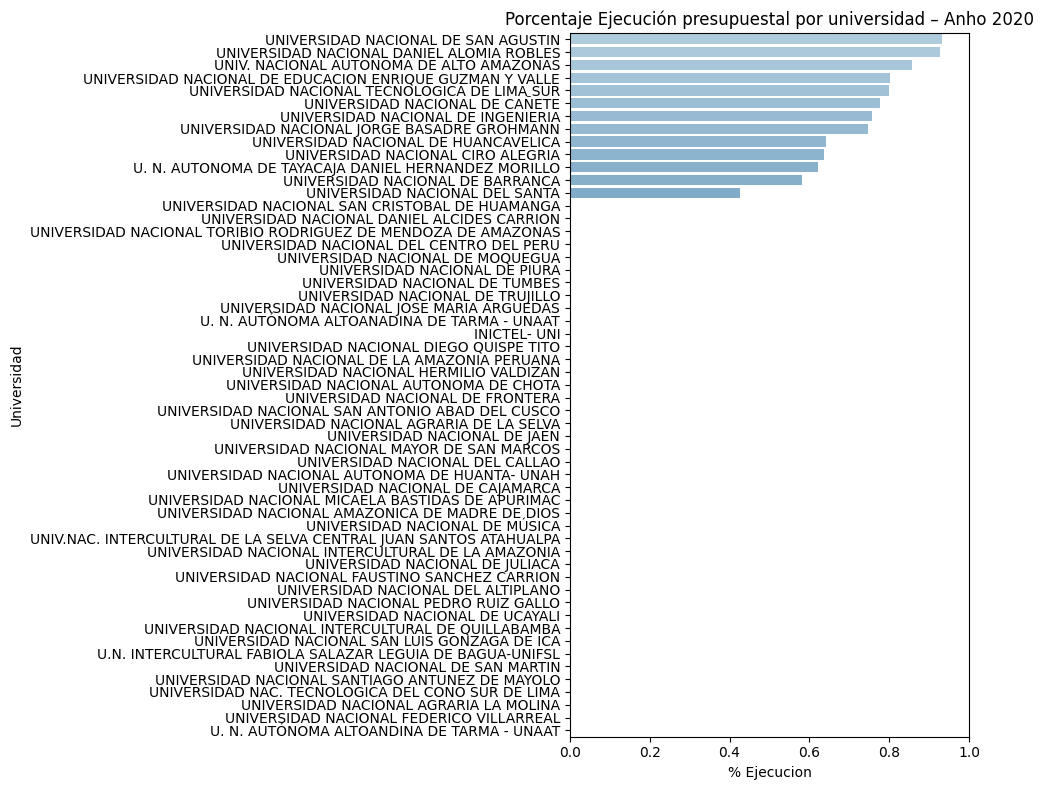

In [38]:
df_2020 = df_final[df_final['ANIO_ID'] == 2020].copy()
df_2020 = df_2020.sort_values('porc_ejecucion', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_2020,
    y='NOMBRE',
    x='porc_ejecucion',
    hue='NOMBRE',
    palette='Blues_d',
    dodge=False,
    legend=False
)

plt.xlabel('% Ejecucion')
plt.ylabel('Universidad')
plt.title('Porcentaje Ejecución presupuestal por universidad – Anho 2020')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()